# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Matthieu Pilon - PILM17089003, Alexis Lemelin - LEMA14109400, Robin St-Georges -        |
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | A2018                                                   |
| Groupe                | 02                                                      |
| Numéro du laboratoire | 1                                                       |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Pier-Luc Delisle                                        |
| Date                  | DATE                                                    |

In [63]:
import numpy as np
import cv2
from sklearn import tree
from skimage import io
from PIL import Image
from core.feature_extraction.galaxy import galaxy_processor 

import random as rand
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot

In [47]:
imgPath = "data/images/"
gp = galaxy_processor.GalaxyProcessor(imgPath)

galaxyDict = []
imgDict = []

# définition des classes
classes = ["smooth","spiral"]

# matrice x contenant toutes les images (nombre d'image, nombre de canaux(RGB), hauteur, largeur)
x = []

# matrice y contenant les étiquettes (nombre d'image, la classe)
y = []

# matrice primInfo contenant les informations voulues des images (nombre d'image, % ratio pixel blanc vs pixel noir, 
# ratio bleu rouge, différence de distance du point le plus brillant au 
# point noir le plus proche horizontallement et verticallement)
primInfo = []

# matrice contenant les images 
img_list = []

print("checkpoint 1")

with open("data/csv/galaxy/galaxy_label_data_set.csv") as fid:    # Execute la lecture du fichier et le ferme automatiqument apres la sortie du bloc de code
    fid.readline()
    next(fid)    # Skip la premiere ligne du fichier (id, classe)
    for line in fid:
        # séparation des informations    
        currentLineInfo = line.split(',')

        # localiser l'image et obtenir les informations voulues
        img = io.imread(imgPath + currentLineInfo[0] + '.jpg')

        # obtenir les informations de l'image
        imgInformations = img.shape

        # ajouter les informations pertinentes aux listes
        x.append([currentLineInfo[0],imgInformations[2],imgInformations[0],imgInformations[1]])
        y.append([currentLineInfo[0],currentLineInfo[1].rstrip()])

        # sauvegarde de l'image dans la liste
        img_list.append(img)
    print("checkpoint 2")   
  

checkpoint 1
checkpoint 2


In [48]:
# compteur d'acces
pos = 0

print ("checkpoint 3")

# trouver les informations des primitives et les mettre dans la matrice des primitives
for img in img_list:
    #variables compteur
    compteurBlanc = 0
    compteurNoir = 0
    
    # Ratio
    
    # converti l'image en grayscale
    img_grayscale = np.array(Image.fromarray(img).convert('L'))
    
    # défini grace a numpi si un pixel doit être noir ou blanc dans le tableau
    black_white_array = np.asarray(img_grayscale).copy()
    black_white_array[black_white_array < 128] = 0
    black_white_array[black_white_array >= 128] = 255
    
    #compter combier des pixel blanc et noir sont dans l'image
    for pixelrow in black_white_array:
        for pixel in pixelrow:
            if pixel == 255:
                compteurBlanc += 1
            elif pixel == 0:
                compteurNoir += 1
    
    #calcule du % grâce au nombre de pixel blanc et noir
    centi = (compteurBlanc / (compteurBlanc + compteurNoir)) *100 
    
    # ratio bleu/rouge
    nbBleu = 0
    nbRouge = 0
    
    # on trouve le nombre de bleu
    bleuMini = np.array([155,0,0], np.uint8)
    bleuMax = np.array([255,50,50], np.uint8)
    
    newImageArray = cv2.inRange(img, bleuMini, bleuMax)
    nbBleu = cv2.countNonZero(newImageArray)
    
    # on trouve le nombre de rouge
    rougeMini = np.array([0,0,155], np.uint8)
    rougeMax = np.array([50,50,255], np.uint8)
    
    newImageArray = cv2.inRange(img, rougeMini, rougeMax)
    nbRouge = cv2.countNonZero(newImageArray)
    
    # création du ratio
    if(nbRouge != 0):
        RatioBleuRouge = nbBleu / nbRouge 
    elif(nbRouge == 0):
        if(nbBleu == 0):
            RatioBleuRouge = 1
        else:
            RatioBleuRouge = nbBleu
    
    # Distance
    distance = 0
    
    # trouver le point le plus brillant
    imgCopy = img
    grayScaleCopy = np.asarray(img_grayscale).copy()
    grayScaleCopy = cv2.GaussianBlur(grayScaleCopy,( 15, 15), 0)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(img_grayscale)
    cv2.circle(imgCopy, maxLoc, 15, (255, 0, 0), 2)
    
    # compteur vertical et horizontal
    compteurVert = maxLoc[1]
    compteurHori = maxLoc[0]
    distanceCompteur = 0
    
    # loop verticallement et horizontalement
    while (compteurVert < x[pos][2] and distance == 0):
        
        #check + initialisation de la distance
        if(black_white_array[maxLoc[0]][compteurVert] == 0):
            distance = distanceCompteur
            
        #incrémentation
        distanceCompteur += 1
        compteurVert += 1
        
    compteurVert = maxLoc[1]
    compteurHori = maxLoc[0]
    distanceCompteur = 0
    newDistance = 0
    
    while (compteurVert > 0 and newDistance == 0):
        
        #check + initialisation de la distance
        if(black_white_array[maxLoc[0]][compteurVert] == 0):
            newDistance = distanceCompteur
            
        #incrémentation
        distanceCompteur += 1
        compteurVert -= 1
    
    # regarder laquelle est la plus grande
    if distance < newDistance:
        distanceV = newDistance
    else:
        distanceV = distance
        
    #reset variables
    compteurVert = maxLoc[1]
    compteurHori = maxLoc[0]
    distanceCompteur = 0
    newDistance = 0
    distance = 0
    
     # loop verticallement et horizontalement
    while (compteurHori < x[pos][3] and distance == 0):
        
        #check + initialisation de la distance
        if(black_white_array[compteurHori][maxLoc[1]] == 0):
            distance = distanceCompteur
            
        #incrémentation
        distanceCompteur += 1
        compteurHori += 1
        
    compteurVert = maxLoc[1]
    compteurHori = maxLoc[0]
    distanceCompteur = 0
    newDistance = 0
    
    while (compteurHori > 0 and newDistance == 0):
        
        #check + initialisation de la distance
        if(black_white_array[compteurHori][maxLoc[1]] == 0):
            newDistance = distanceCompteur
            
        #incrémentation
        distanceCompteur += 1
        compteurHori -= 1
        
    # regarder laquelle est la plus grande
    if distance < newDistance:
        distanceH = newDistance
    else:
        distanceH = distance
    
    '''
    # afficher le point le plus brillant comme vérification
    plt.imshow(imgCopy)
    plt.show()
    print(maxLoc)
    '''
    
    # calculer les distances horizontales et verticales vers le point le plus noir
    
    FinalDistance = abs(distanceH - distanceV)
    
    # sauvegarde des informations des primitives dans la liste
    primInfo.append([x[pos][0], centi, RatioBleuRouge, FinalDistance])

    '''
    # printing test to see if all is right
    print(x[pos][0])
    print(RatioBleuRouge)
    print(FinalDistance)
    '''
    
    # incremantation du comteur
    pos  += 1
    
print ("checkpoint 4")



checkpoint 3
checkpoint 4


In [49]:
X = primInfo
Y = []

counter = 0
for yi in y:
    Y.append(y[counter][1]) 
    counter += 1
    


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

In [38]:
print(X)

[['100134', 0.0211374154503382, 1, 0], ['100322', 0.2453052687789249, 1, 4], ['100380', 0.06953097187611249, 1, 1], ['100458', 0.32262370950516195, 1, 1], ['100479', 1.2704699181203274, 1, 3], ['100520', 0.1318307226771093, 1, 4], ['100672', 0.40105464578141686, 2, 0], ['100673', 0.9261525453898184, 1, 0], ['100724', 1.6014373442506231, 1, 5], ['100727', 0.127936988252047, 1, 1], ['100765', 0.2536489854040584, 1, 0], ['100801', 0.6613786044855821, 1, 0]]


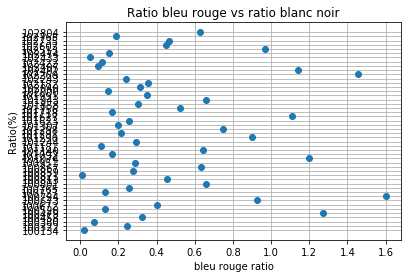

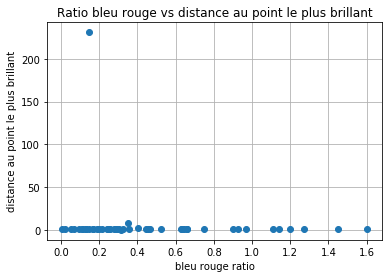

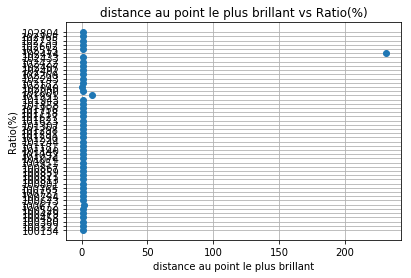

0.3
0.4
0.3
0.3
0.3
0.3


In [67]:
## Plot graphiques
# tracage des différent graphiques pour déterminer le pouvoir discriminent des primitives 
ratioPrimitive = []
bleuRougePrimitive = []
distancePrimitive = []
colorList = []

# on sépare le tableau principale pour montrer les primitives dans leur propre graphique
for infoLine in primInfo:
    ratioPrimitive.append(infoLine[0])
    bleuRougePrimitive.append(infoLine[1])
    distancePrimitive.append(infoLine[2])
    colorList.append('red')

x = bleuRougePrimitive
y = ratioPrimitive

plt.plot(x,y,'o')
plt.xlabel('bleu rouge ratio')
plt.ylabel('Ratio(%)')
plt.title('Ratio bleu rouge vs ratio blanc noir')
plt.grid(True)
plt.show()

x = bleuRougePrimitive
y = distancePrimitive

plt.plot(x,y,'o')
plt.xlabel('bleu rouge ratio')
plt.ylabel('distance au point le plus brillant')
plt.title('Ratio bleu rouge vs distance au point le plus brillant')
plt.grid(True)
plt.show()

x = distancePrimitive
y = ratioPrimitive

plt.plot(x,y,'o')
plt.xlabel('distance au point le plus brillant')
plt.ylabel('Ratio(%)')
plt.title('distance au point le plus brillant vs Ratio(%)')
plt.grid(True)
plt.show()



tree= DecisionTreeClassifier()
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 2)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 3)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 4)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 5)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 10)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))




## Introduction et revue de la littérature

Ce laboratoire porte a nous initié aux pricipes de l'apprentissage machine avec le traitement d'image et la sélection de primitives. Le problème est de diférencier deux type de galaxy selon des images. Suite à l'étude de Devandre Dahmi, la classifiction de primitives était élaborer par certaines catégories afin d'y en choisir 3. Ceux choisi sont le ratio bleu rouge, le ratio noir blanc et la distance ecllipsial du noyau. 

En suivant les suggestion de Dahmi, ces primitives vont être essential à notre evaluation du dataset et l'intégration de la librairie cv2 de python permettera la codification de la théorie.

### Question 1

Contrairement à ce que l’on pourrait croire, les galaxies sont plus difficiles à identifier qu’elles laissent croire. En effet, bien qu’elles possèdent plusieurs caractéristiques uniques qui aident, celles-ci sont souvent plutôt difficiles à identifier dû au bruit dans les images.
Après avoir lu et effectuer nos recherches, plusieurs options possibles/pistes nous sont disponibles pour commencer notre analyse. Par exemple, il nous serait possible d’analyser les filtres de couleur des images, certains ratios, les filtres de Gabor générés ou encore les proportions des galaxies pour identifier leur type.


### Question 2

Afin de compléter le laboratoire, il nous a fallu trouver au minimum trois primitives. Pour trouver celles-ci, nous nous sommes principalement basé sur les options trouvées plus tôt. Celles-ci étant à leur tour basées sur les documents qui nous ont été fournis, ainsi que les quelques recherches que nous avons effectués sur le web.
Après élimination des primitives qui nous semblaient superflues ou trop compliqué, nous avons décidé de sélectionner le ratio de blanc sur noir, le ratio des pixels bleus sur rouges et la différence entre la longueur verticale et horizontale partant du point le plus brillant de l'image comme primitives de notre analyse. Celles-ci nous semblaient les plus pertinentes tout en restant assez simple.


### Question 3

![alt text](https://cdn.discordapp.com/attachments/497400582441795634/499781253504172042/unknown.png)

![alt text](https://media.discordapp.net/attachments/497400582441795634/499781482215374848/unknown.png)

Le ratio bleu rouge et le ratio blanc noir sont des primitives discriminantes selon notre évaluation. Le graphique comporte une répartition de donné significative comparer aux autres combinaisons des primitives choisis. Les autres combinaisons sont tous regroupés sans distinctions. Par contre, la taille de l’échantillon limite la précision des primitives. À 50, le travail est trop petit pour être significatif.

### Question 4

L’arbre de décision a donné le meilleur score de précision lorsque la profondeur est à 2 à 40%. Les autres profondeurs évaluer (aucune, 3, 4, 5 et 10) ont toutes retournés une précision d’environs 30%. Par contre, la taille de l’échantillon a été réduite à 50 afin d'adéquatement évaluer avec le temps constraint. La taille réduites a affecté la précision du résultat. Estimant que l’entièreté du dataset a été traité, une plus grande profondeur aura porté une plus grande précision. Par contre il faut prendre en compte le over et under fitting, jouez avec les paramètres afins de maximiser l’évaluation des donnés.

### Question 5

Il nous aurait été possible d’ajouter un filtre de Gabor précis dans le but d’identifier certaines lignes droites possibles dans une galaxie particulière. Ceci nous aurait permis d’identifier par la suite avec une assez bonne précision les spirales visibles dans les galaxies.

### Conclusion

À l’aide des revues scientifiques, déterminer les primitives était une tâche moins ardu que de les programmer. En évaluant la totalité du dataset, le temps d’exécution achevait deux heures, sinon plus. Évaluer la distance du noyau, le ratio des pixels grayscale et le ratio d’intensité rouge et bleu a permis d’obtenir un ratio de succès d’environs 40%. La précision faible des primitives est liée dans une implémentation en bloc qui a limité la performance globale en grugeant les ressources du processeur en traitant les 3 primitives une image à la fois. Implémenter un traitement parallèle et implémenter une mentalité plus orienté-objet, le résultat final aurait pu porter un traitement plus accélérer. Le travail fait en jupyter notebook a aussi causé quelque problème de synchronisation parmis l’équipe. Cependant, c’est un petit problème qui sera réglé d’ici la prochaine itération.

### Bibliographie

Dhami, Devendra; (2015); Morphological classification of galaxies into spirals and non-spirals 